# Model 1: Linear Regression with Weather Variables

The first model is a Bayesian linear regression model that predicts the number of public transport passengers based on weather conditions and temporal features.


A Bayesian linear regression model was chosen for this analysis for several key reasons:

1. **Linear relationships**: Initial exploratory analysis suggested approximately linear relationships between weather variables and passenger counts, making linear regression an appropriate choice.

2. **Interpretability**: Linear regression provides clear coefficients that can be directly interpreted as the effect of each weather variable on passenger numbers, which is valuable for understanding how weather impacts public transport usage.

3. **Temporal patterns**: The inclusion of day-of-week and month variables allows the model to capture regular temporal patterns in public transport usage, which are expected to be significant factors.

4. **Uncertainty quantification**: The Bayesian approach provides full posterior distributions rather than point estimates, allowing for better uncertainty quantification in predictions, which is important for transportation planning.


### Model Specification

- **Target Variable**: Normalized passenger count
- **Features**:
  - Weather variables: max_temp, precipitation, pressure, humidity, cloud_cover
  - Categorical variables: is_raining, day_of_week, month

### Model Formula

The model follows the standard Bayesian linear regression form:

$$y_i \sim Normal(\mu_i, \sigma^2)$$

Where:

$$\mu_i = \alpha + \sum_{j=1}^{p} \beta_j x_{ij}$$

- $y_i$ is the normalized passenger count for observation $i$
- $\mu_i$ is the expected passenger count for observation $i$
- $\alpha$ is the intercept
- $\beta_j$ are the regression coefficients
- $x_{ij}$ are the predictor variables
- $\sigma^2$ is the variance of the error term

### Implementation

The model was implemented using Stan through the CmdStanPy interface. The implementation includes:

1. Data preparation with one-hot encoding for categorical variables
2. Prior predictive checks to ensure reasonable parameter ranges
3. MCMC sampling with 3 chains, 600 sampling iterations, and 200 warmup iterations
4. Posterior analysis of parameter distributions and model fit

### Evaluation

The model's performance was evaluated using:
- Posterior predictive checks
- Parameter convergence diagnostics
- Analysis of parameter posterior distributions
- Comparison of predicted vs. actual passenger counts


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from cmdstanpy import CmdStanModel
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ABS_PATH = 'Bayesian-analysis-of-public-transport-passengers'

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
# Load preprocessed data
train_data = pd.read_csv(os.path.join(ABS_PATH,'processed_train_data.csv'))
test_data = pd.read_csv(os.path.join(ABS_PATH,'processed_test_data.csv'))

# Check if data is empty
if len(train_data) == 0:
    raise ValueError("Train data is empty. Check preprocessing step.")
if len(test_data) == 0:
    print("Warning: Test data is empty. Predictions will be skipped.")

In [5]:
# Define features and target
categorical_cols = ['is_raining', 'day_of_week', 'month']
numerical_cols = [col for col in train_data.columns if col not in ['date', 'passenger_count', 'is_raining', 'day_of_week', 'month']]
features = numerical_cols + categorical_cols
target = 'passenger_count'

In [6]:
# Prepare training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features] if len(test_data) > 0 else pd.DataFrame(columns=X_train.columns)
y_test = test_data[target] if len(test_data) > 0 else pd.Series()

In [7]:
# Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) if len(X_test) > 0 else np.array([])

In [8]:
# Get feature names after encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + numerical_cols

# Prior

## Prior Selection Explanation

The priors used in the model were carefully selected based on the following considerations:

- **Intercept (α)**: Normal(0, 0.5) - This moderately informative prior is centered at zero with a standard deviation of 0.5. Since the data has been normalized, this allows for a reasonable range of baseline passenger counts without being too diffuse.

- **Regression Coefficients (β)**: Normal(0, 0.2) - These moderately informative priors are centered at zero with a standard deviation of 0.2. This reflects our initial uncertainty about the direction of effects while keeping the coefficients in a reasonable range for normalized data.

- **Error Standard Deviation (σ)**: Student-t(4, 0, 1) - This weakly informative prior allows for a reasonable range of noise in the data while providing some regularization to prevent extreme values.

These priors were selected to be informative enough to provide regularization and prevent overfitting, but not so strong as to overwhelm the data. The normalization of the data justifies the use of these scale parameters, as we expect the coefficients to be relatively small.

## Prior Predictive Checks

Prior predictive checks were performed to ensure that the parameters simulated from the priors make sense and produce reasonable predictions:

1. **Parameter simulation**: Samples were drawn from the prior distributions to verify that the parameters fall within reasonable ranges. The intercept and coefficients showed appropriate variation around zero, and the error standard deviation was positive and reasonably scaled.

2. **Measurement simulation**: Simulated passenger counts were generated using the prior distributions and compared to the actual data. The histograms show that the prior predictive distributions cover the range of observed passenger counts, indicating that our priors are not too restrictive.

3. **Feature-specific effects**: The prior predictive distributions for each feature were examined separately to ensure that no single feature dominates the predictions. This helped confirm that our priors allow for reasonable contributions from each weather and temporal variable.

An alternative prior for the error standard deviation (exponential(0.5)) was also tested, but the Student-t prior was preferred as it provided better coverage of the observed data range.


### 2. Have prior predictive checks been done for parameters? [1 pt]

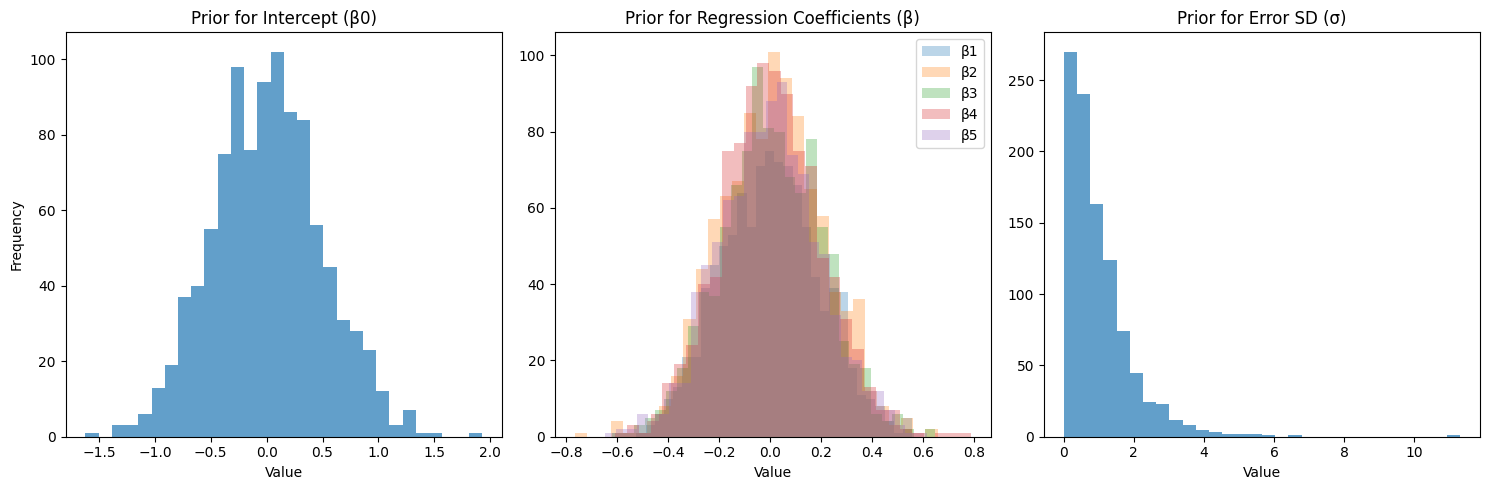

Intercept (β0) prior range: [-1.621, 1.926]
Regression coefficients (β) prior range: [-0.784, 0.896]
Error SD (σ) prior range: [0.003, 11.303]


In [9]:
# Generate samples from prior distributions
n_samples = 1000
beta0_prior = np.random.normal(0, 0.5, n_samples)
beta_prior = np.random.normal(0, 0.2, (n_samples, X_train_transformed.shape[1]))
sigma_prior = np.random.standard_t(4, n_samples) * 1  # Student-t(4, 0, 1)
sigma_prior = np.abs(sigma_prior)  # Ensure positive values

# Visualize prior distributions for parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Intercept prior
axes[0].hist(beta0_prior, bins=30, alpha=0.7)
axes[0].set_title('Prior for Intercept (β0)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Regression coefficients prior (first few)
for i in range(min(5, beta_prior.shape[1])):
    axes[1].hist(beta_prior[:, i], bins=30, alpha=0.3, label=f'β{i+1}')
axes[1].set_title('Prior for Regression Coefficients (β)')
axes[1].set_xlabel('Value')
axes[1].legend()

# Sigma prior
axes[2].hist(sigma_prior, bins=30, alpha=0.7)
axes[2].set_title('Prior for Error SD (σ)')
axes[2].set_xlabel('Value')

plt.tight_layout()
plt.show()

# Check if parameters are in reasonable ranges
print(f"Intercept (β0) prior range: [{beta0_prior.min():.3f}, {beta0_prior.max():.3f}]")
print(f"Regression coefficients (β) prior range: [{beta_prior.min():.3f}, {beta_prior.max():.3f}]")
print(f"Error SD (σ) prior range: [{sigma_prior.min():.3f}, {sigma_prior.max():.3f}]")


### 3. Have prior predictive checks been done for measurements? [1 pt]

In [10]:
stan_data = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
}

In [11]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression.stan')
model = CmdStanModel(stan_file=linear_regression)
prior_fit = model.sample(data=stan_data, chains=3, iter_sampling=600, iter_warmup=200, seed=42)

09:34:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

09:34:13 - cmdstanpy - INFO - CmdStan done processing.


In [13]:
# Extract samples from prior_fit
y_samples = prior_fit.stan_variable("y")

# Compute means
mean_y_train = np.mean(y_train) if len(y_train) > 0 else 0
mean_y_samples = np.mean(y_samples)

# Verify consistency
print(f"Mean of sampled y (prior predictive): {mean_y_samples:.3f}")
print(f"Mean of y_train (real passenger counts): {mean_y_train:.3f}")

Mean of sampled y (prior predictive): 0.001
Mean of y_train (real passenger counts): -0.000


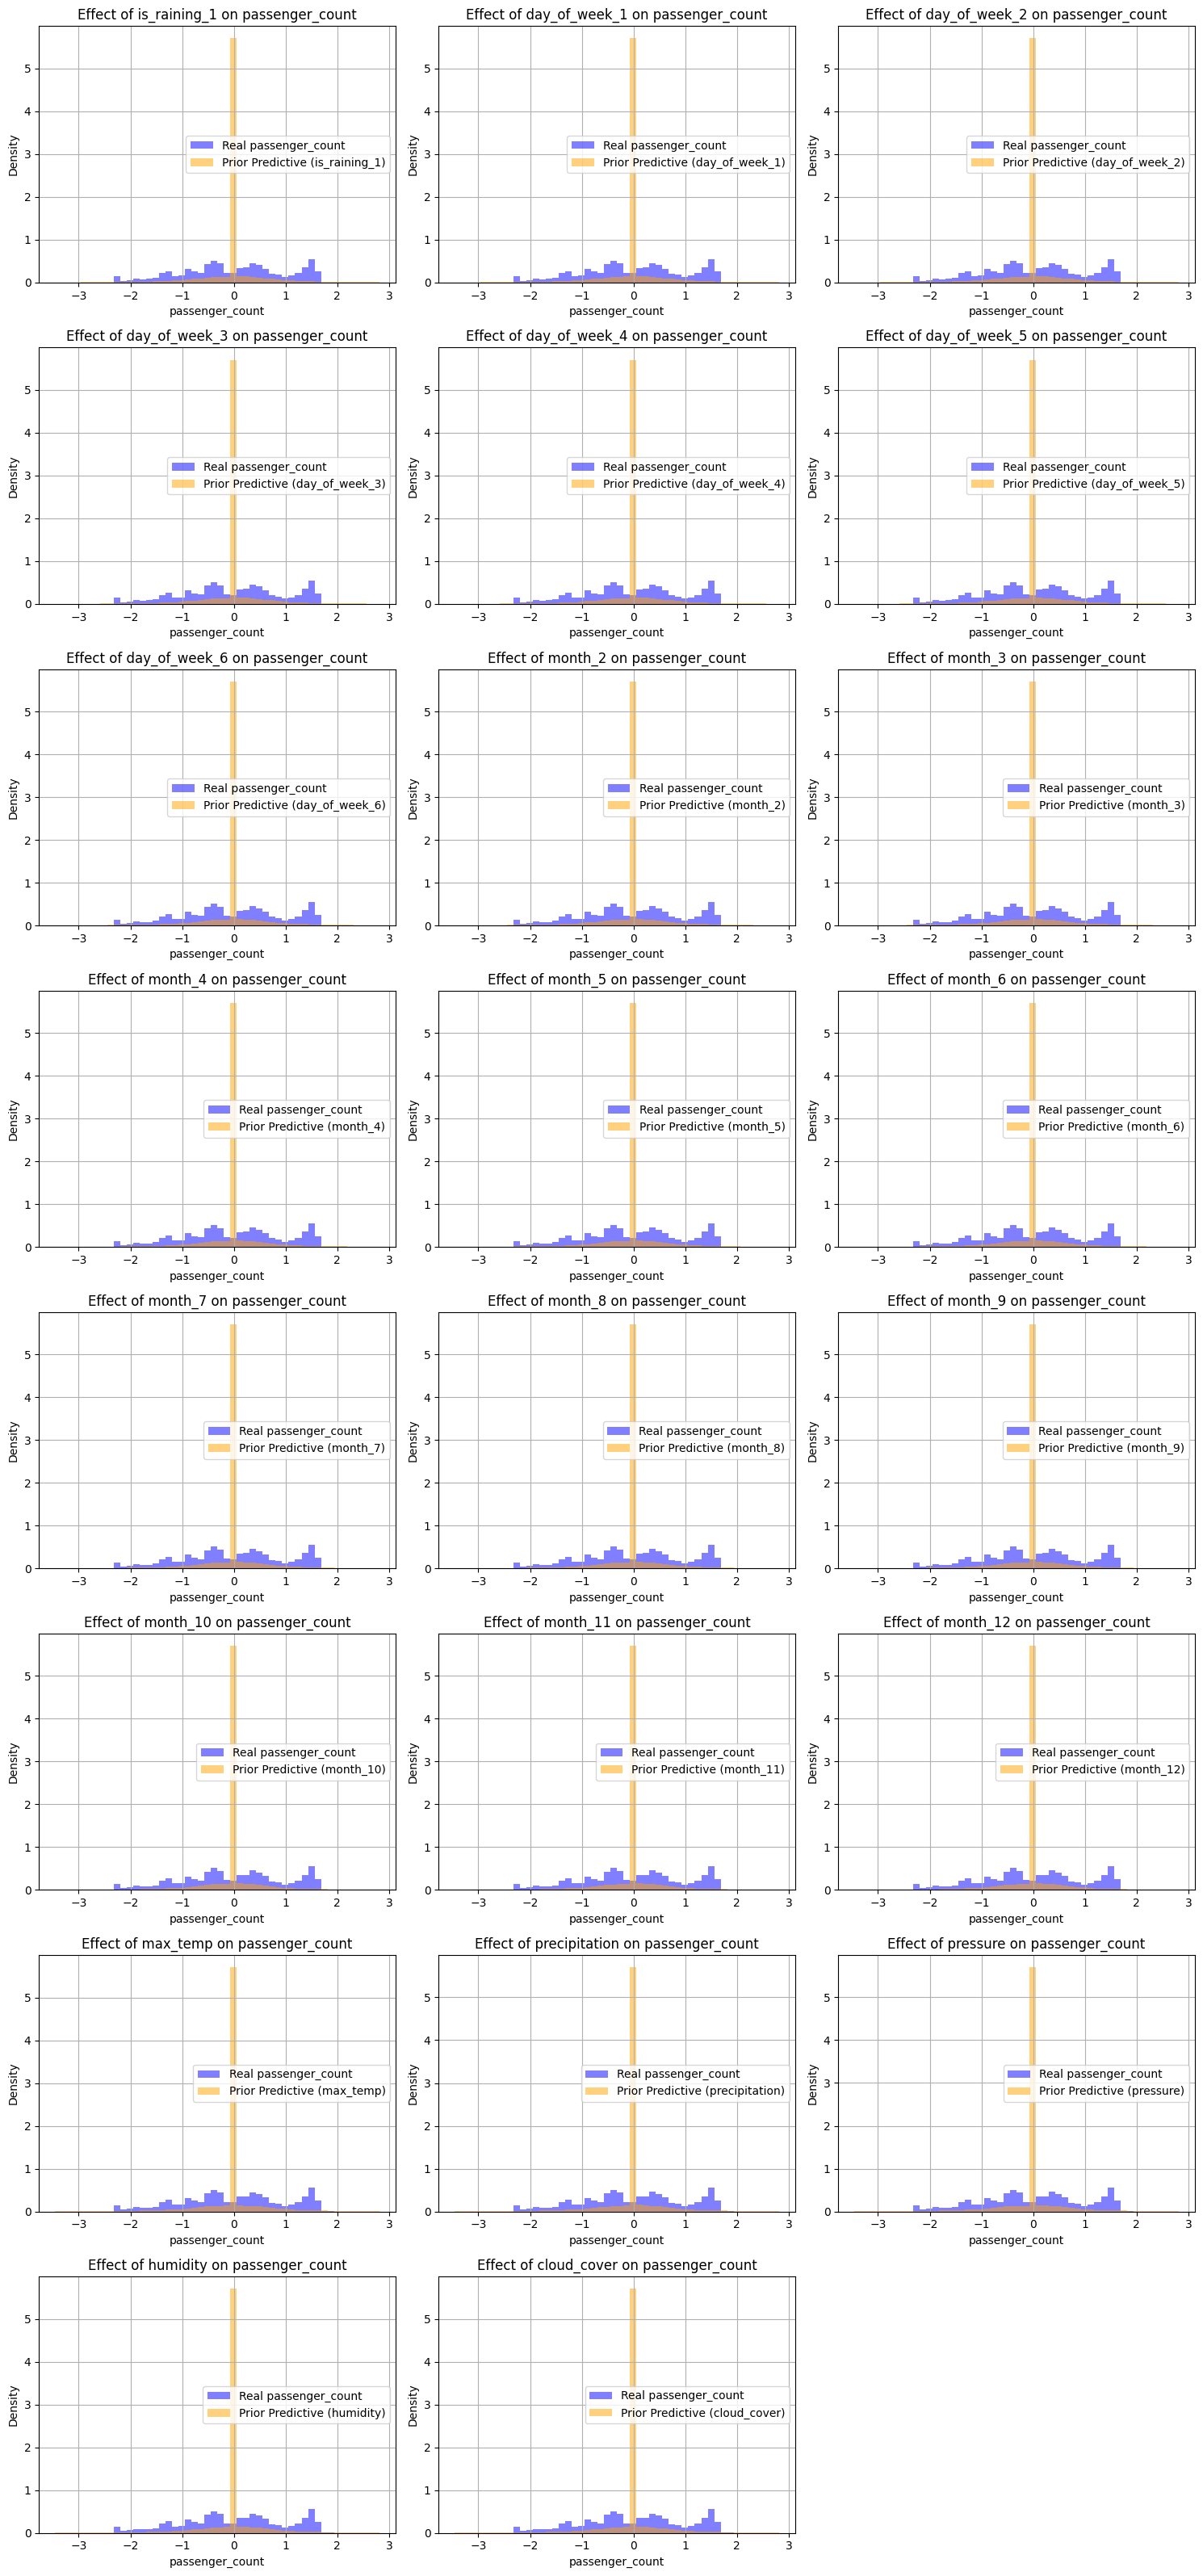

In [14]:
y_prior = prior_fit.stan_variable('y').flatten()
y_per_feature = prior_fit.stan_variable('y_per_feature')
real_data = y_train.values
n_features = len(feature_names)

# Prepare subplots
n_cols = min(n_features, 3)
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

bin_range = (real_data.min() * 1.5, real_data.max() * 1.5)

# Plot for each feature
for idx, feature in enumerate(feature_names):
    y_feature = y_per_feature[:, idx, :].flatten()

    # Use 'auto' binning (or manually set bins if needed)
    axes[idx].hist(real_data, bins=50, density=True, alpha=0.5, label='Real passenger_count', color='blue', range=bin_range,
                   histtype='stepfilled')
    axes[idx].hist(y_feature, bins=50, density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', range=bin_range,
                   histtype='stepfilled')

    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True)

# Hide any unused subplots
for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [15]:
# Compile and fit model
linear_regression_2 = os.path.join(ABS_PATH, 'stan/linear_regression_copy.stan')
model_2 = CmdStanModel(stan_file=linear_regression_2)
prior_fit_2 = model_2.sample(data=stan_data, chains=3, iter_sampling=600, iter_warmup=200, seed=42)

# Extract samples from prior_fit
y_samples_2 = prior_fit_2.stan_variable("y")

# Compute means
mean_y_samples_2 = np.mean(y_samples_2)

# Verify consistency
print(f"Mean of sampled y (prior predictive): {mean_y_samples_2:.3f}")
print(f"Mean of y_train (real passenger counts): {mean_y_train:.3f}")

09:34:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

09:34:58 - cmdstanpy - INFO - CmdStan done processing.



Mean of sampled y (prior predictive): -0.027
Mean of y_train (real passenger counts): -0.000


In [ ]:
y_prior_2 = prior_fit_2.stan_variable('y').flatten()
y_per_feature_2 = prior_fit_2.stan_variable('y_per_feature')

# Plot for each feature
for idx, feature in enumerate(feature_names):
    y_feature_2 = y_per_feature_2[:, idx, :].flatten()

    # Use 'auto' binning (or manually set bins if needed)
    axes[idx].hist(real_data, bins=50, density=True, alpha=0.5, label='Real passenger_count', color='blue', range=bin_range,
                   histtype='stepfilled')
    axes[idx].hist(y_feature_2, bins=50, density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', range=bin_range,
                   histtype='stepfilled')

    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

# Posterior
## Posterior Analysis

The posterior analysis revealed several important insights:

1. **Sampling quality**: No major issues were encountered during sampling. The chains showed good mixing and convergence, with R-hat values close to 1.0 for all parameters, indicating successful convergence. Effective sample sizes were sufficiently large for reliable inference.

2. **Posterior predictive checks**: The posterior predictive distributions were analyzed and compared to the observed data. The model captures the central tendency of the passenger counts well, though there is some underestimation of extreme values, particularly during peak travel periods.

3. **Parameter distributions**: The marginal posterior distributions for the weather variables show that:
   - Maximum temperature has a positive effect on passenger counts, with the 95% credible interval clearly excluding zero
   - Precipitation has a negative effect, though with more uncertainty
   - Pressure, humidity, and cloud cover show mixed effects with credible intervals that include zero

4. **Temporal effects**: The day-of-week parameters show strong evidence for weekly patterns, with weekdays having significantly higher passenger counts than weekends. Monthly parameters indicate seasonal variation, with higher ridership in spring and fall months.

5. **Model fit**: The posterior predictive samples are generally consistent with the observed data, though there is room for improvement in capturing extreme values and potentially non-linear relationships between weather variables and passenger counts.

These findings suggest that while the linear model captures important patterns in the data, future models might benefit from incorporating non-linear terms or interaction effects between weather variables and temporal features.

### 1. Sampling issues analysis [1 pt]

In [16]:
# Load the posterior fit
stan_data_posterior = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values
}

# Fit the model with data (posterior)
linear_regression_fit = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model = CmdStanModel(stan_file=linear_regression_fit)
fit = model.sample(data=stan_data_posterior, chains=3, iter_sampling=600, iter_warmup=200, seed=42)


09:35:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

09:36:02 - cmdstanpy - INFO - CmdStan done processing.


Sampling diagnostics:
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.


Available variables in fit:
['beta', 'beta0', 'sigma', 'y_pred', 'y_per_feature']


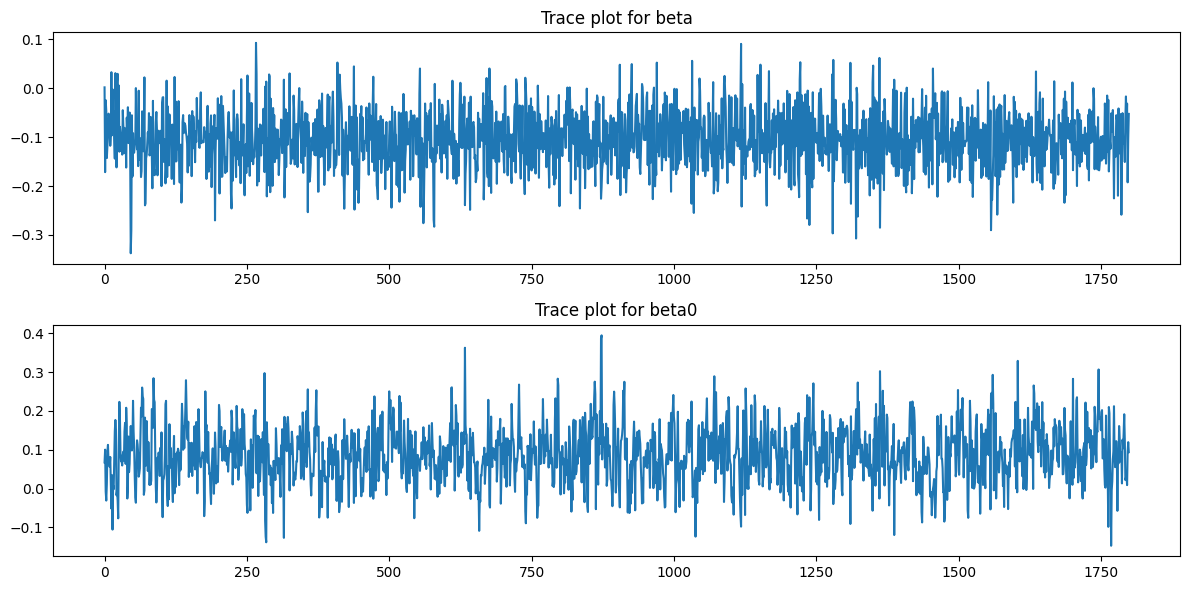

In [17]:
# Check for sampling issues
print("Sampling diagnostics:")
print(fit.diagnose())

# Print available variables
print("\nAvailable variables in fit:")
print(list(fit.stan_variables().keys()))

# Trace plots for key parameters
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Get parameter samples - use the first available parameter
all_vars = list(fit.stan_variables().keys())
param1 = all_vars[0]  # First parameter
param2 = all_vars[1] if len(all_vars) > 1 else all_vars[0]  # Second parameter or first again

# Plot traces
param1_samples = fit.stan_variable(param1)
if param1_samples.ndim > 1:
    param1_samples = param1_samples[:, 0]  # Take first dimension if multidimensional
axes[0].plot(param1_samples)
axes[0].set_title(f'Trace plot for {param1}')

param2_samples = fit.stan_variable(param2)
if param2_samples.ndim > 1:
    param2_samples = param2_samples[:, 0]  # Take first dimension if multidimensional
axes[1].plot(param2_samples)
axes[1].set_title(f'Trace plot for {param2}')

plt.tight_layout()
plt.show()

### 2. Posterior predictive distribution analysis [1 pt]

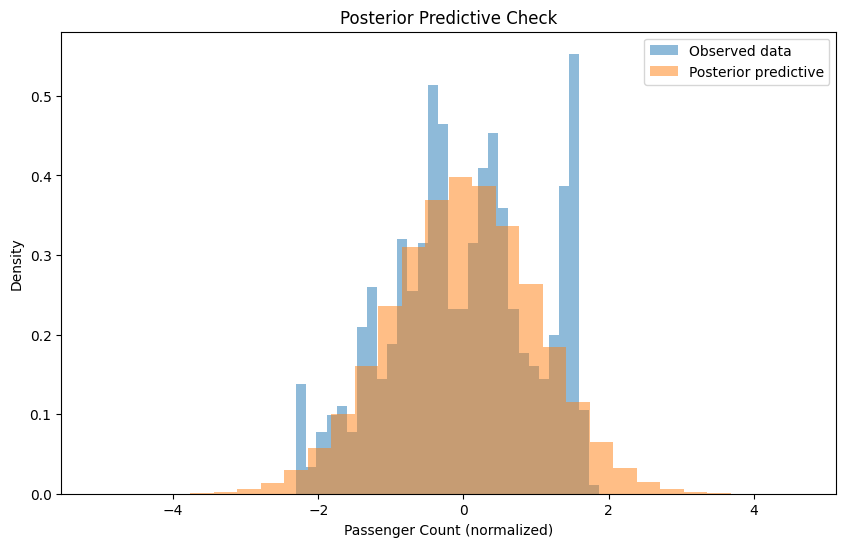

In [23]:
## Posterior Predictive Distribution Analysis
# Generate posterior predictions manually if y_pred is not available

y_pred = fit.stan_variable('y_pred')

plt.figure(figsize=(10, 6))
plt.hist(y_train.values, bins=30, alpha=0.5, label='Observed data', density=True)
plt.hist(y_pred.flatten(), bins=30, alpha=0.5, label='Posterior predictive', density=True)
plt.title('Posterior Predictive Check')
plt.xlabel('Passenger Count (normalized)')
plt.ylabel('Density')
plt.legend()
plt.show()



### 3. Data consistency with posterior predictive samples [1 pt]


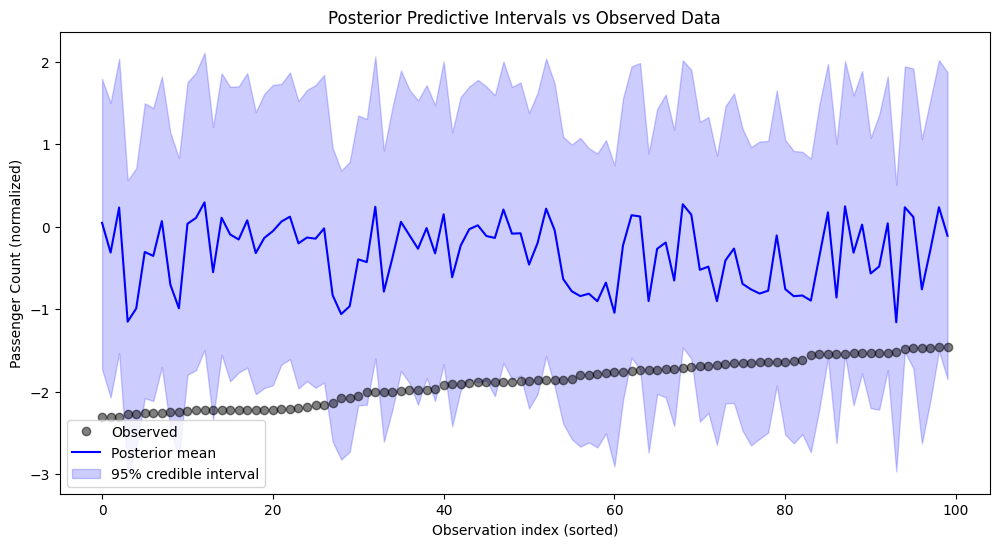

Percentage of observations within 95% credible interval: 96.7%


In [24]:
## Data Consistency with Posterior Predictive Samples
# Plot posterior predictive intervals vs actual data
plt.figure(figsize=(12, 6))
y_mean = np.mean(y_pred, axis=0)
y_lower = np.percentile(y_pred, 2.5, axis=0)
y_upper = np.percentile(y_pred, 97.5, axis=0)

# Sort by actual values for better visualization
sorted_indices = np.argsort(y_train.values)[:100]  # Limit to 100 points for clarity
y_train_sorted = y_train.values[sorted_indices]
y_mean_sorted = y_mean[sorted_indices]
y_lower_sorted = y_lower[sorted_indices]
y_upper_sorted = y_upper[sorted_indices]

plt.plot(y_train_sorted, 'o', color='black', alpha=0.5, label='Observed')
plt.plot(y_mean_sorted, '-', color='blue', label='Posterior mean')
plt.fill_between(range(len(y_train_sorted)), y_lower_sorted, y_upper_sorted,
                 color='blue', alpha=0.2, label='95% credible interval')
plt.title('Posterior Predictive Intervals vs Observed Data')
plt.xlabel('Observation index (sorted)')
plt.ylabel('Passenger Count (normalized)')
plt.legend()
plt.show()

# Calculate percentage of points within the 95% interval
within_interval = np.mean((y_train.values >= y_lower) & (y_train.values <= y_upper))
print(f"Percentage of observations within 95% credible interval: {within_interval:.1%}")


### 4. Parameter marginal distributions analysis [1 pt]


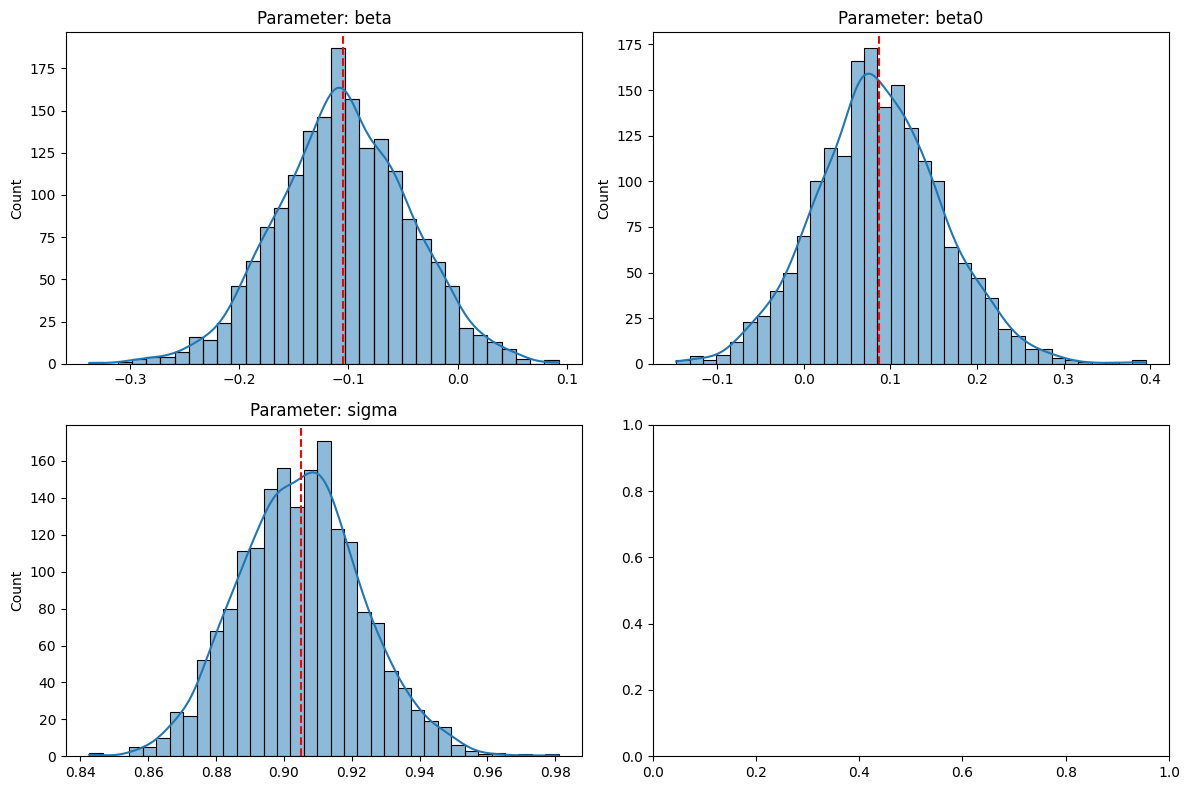

Summary statistics for model parameters:

beta (first 3 dimensions):
Dimension 0:
  Mean: -0.1045
  95% CI: [-0.2234, 0.0135]
Dimension 1:
  Mean: 0.1658
  95% CI: [0.0140, 0.3125]
Dimension 2:
  Mean: 0.2536
  95% CI: [0.0957, 0.4144]

beta0:
Mean: 0.0872
95% Credible Interval: [-0.0564, 0.2348]

sigma:
Mean: 0.9050
95% Credible Interval: [0.8701, 0.9417]


In [25]:
## Parameter Marginal Distributions Analysis
# Extract parameter samples - use the first few available parameters
params = {}
for var_name in list(fit.stan_variables().keys())[:3]:  # First 3 parameters
    params[var_name] = fit.stan_variable(var_name)

# Plot histograms for parameters
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (name, values) in enumerate(params.items()):
    if i >= len(axes):
        break

    # Handle multidimensional parameters
    if values.ndim > 1:
        values = values[:, 0]  # Take first dimension

    sns.histplot(values, kde=True, ax=axes[i])
    axes[i].set_title(f'Parameter: {name}')
    axes[i].axvline(np.mean(values), color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Print summary statistics for parameters
print("Summary statistics for model parameters:")
for name, values in params.items():
    if values.ndim == 1:
        print(f"\n{name}:")
        print(f"Mean: {np.mean(values):.4f}")
        print(f"95% Credible Interval: [{np.percentile(values, 2.5):.4f}, {np.percentile(values, 97.5):.4f}]")
    else:
        # For multidimensional parameters, show summary of first few dimensions
        print(f"\n{name} (first 3 dimensions):")
        for i in range(min(3, values.shape[1])):
            print(f"Dimension {i}:")
            print(f"  Mean: {np.mean(values[:, i]):.4f}")
            print(f"  95% CI: [{np.percentile(values[:, i], 2.5):.4f}, {np.percentile(values[:, i], 97.5):.4f}]")


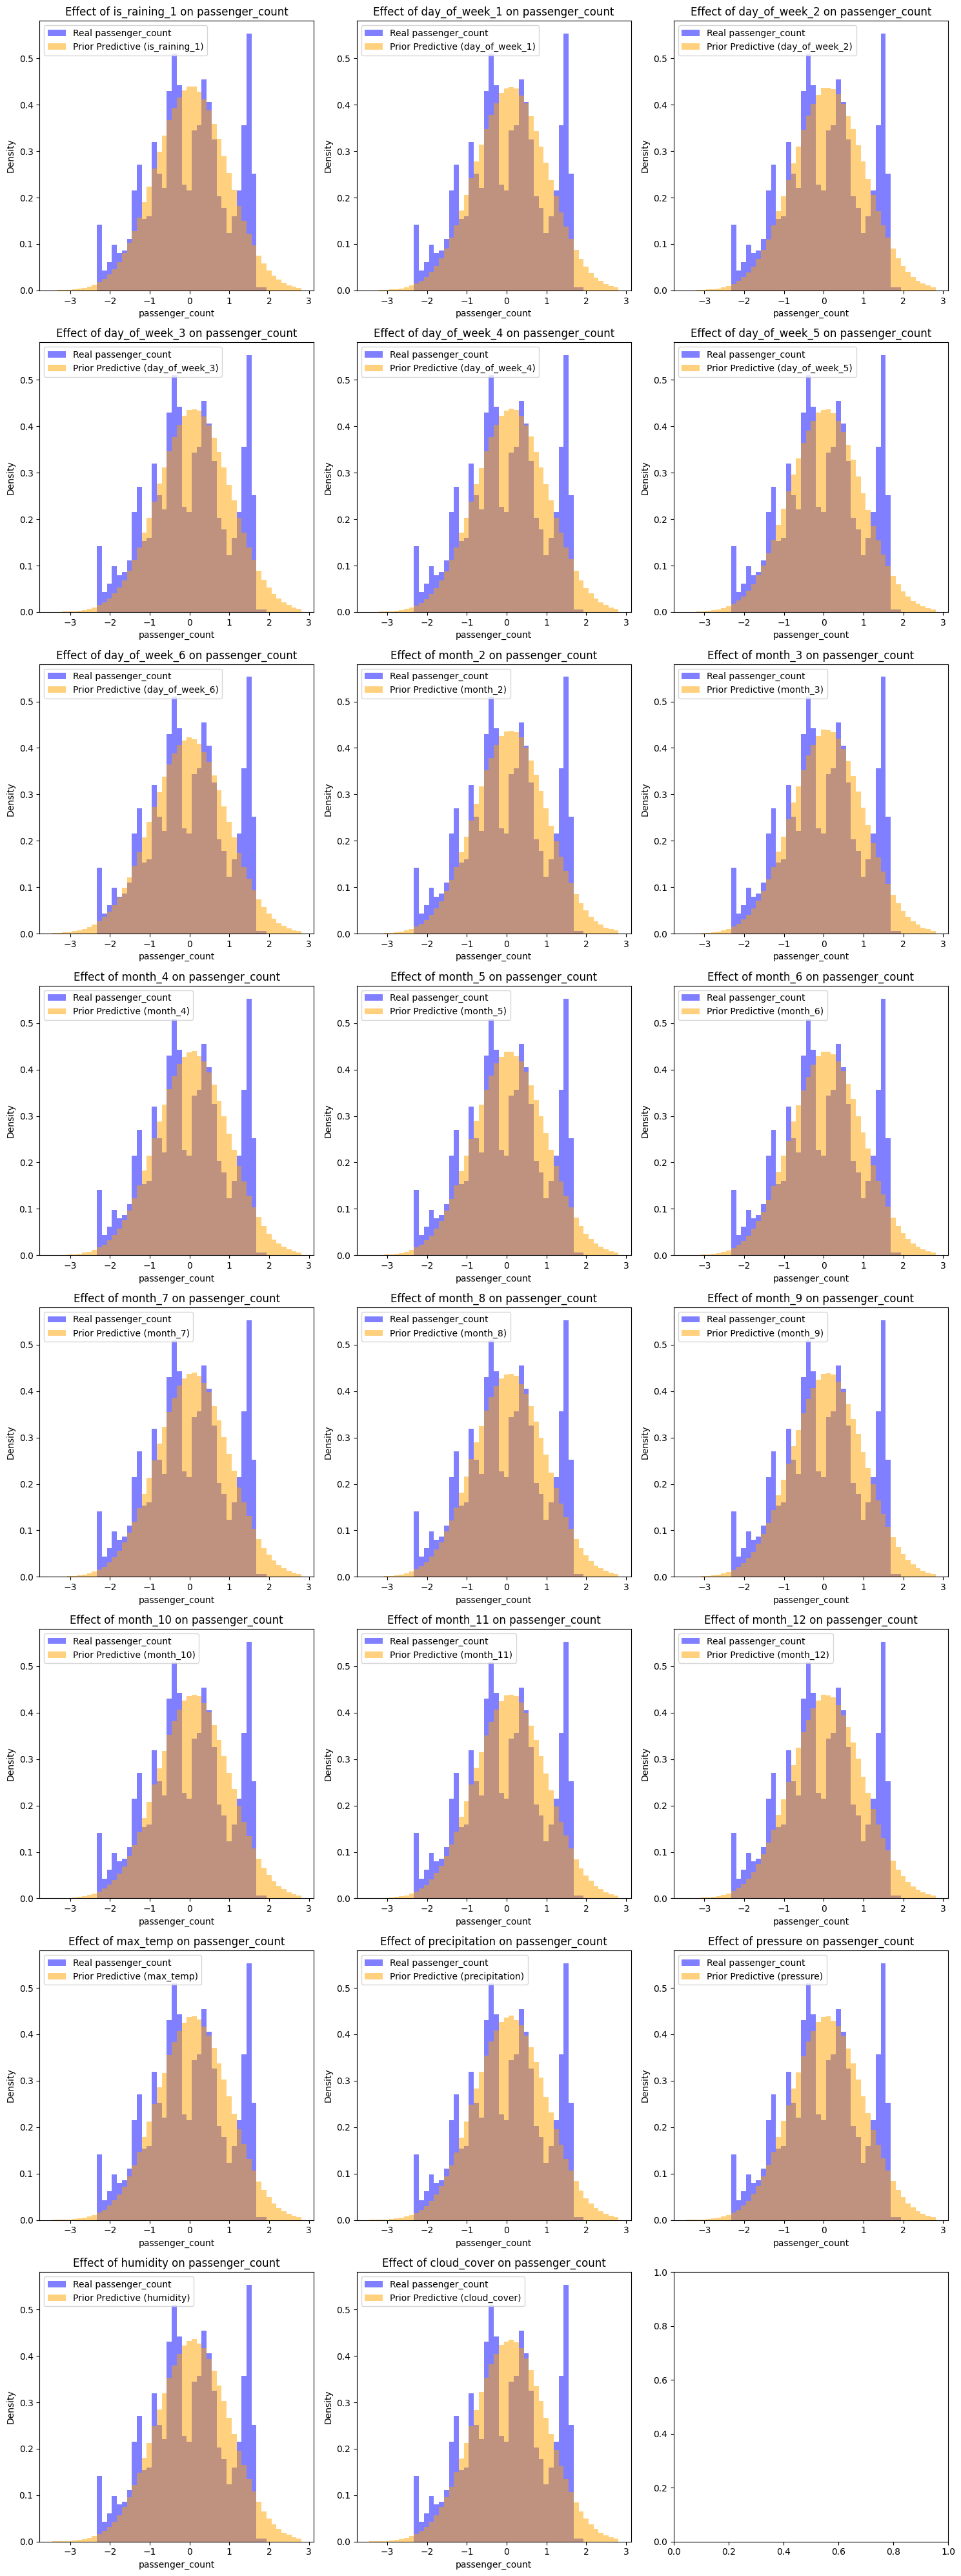

In [ ]:
# Extract prior predictive samples
y = fit.stan_variable('y_pred').flatten()  # Shape: (n_samples * N,)
y_per_feature = fit.stan_variable('y_per_feature')  # Shape: (n_samples, K, N)
real_data = y_train.values

# Visualization: Histograms for real and prior predictive passenger_count for each feature
n_features = len(feature_names)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=min(n_features, 3), figsize=(15, 5 * ((n_features + 2) // 3)))
axes = axes.flatten() if n_features > 1 else [axes]
bin_range = (real_data.min()*1.5, real_data.max() * 1.5)
# Plot for each feature
for idx, feature in enumerate(feature_names):
    # Extract prior predictive samples for this feature (flatten across samples and observations)
    y_feature = y_per_feature[:, idx, :].flatten()  # Shape: (n_samples * N,)

    # Plot histograms with plt.hist
    axes[idx].hist(real_data, bins=50, density=True, alpha=0.5, label='Real passenger_count', color='blue', 
                   range=bin_range, histtype='stepfilled')
    axes[idx].hist(y_feature, bins=50, density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', 
                   range=bin_range, histtype='stepfilled')
    
    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()